# 3. Train a LSTM for Ozone Forecasting

## Introduction

**Purpose:** This notebook is used to train a long short-term memory (LSTM) neural network to generate a 24-hour ozone forecast.

**Contents:** The notebook contains:
* Model training
* Validation of the model
* Determination of the model's accuracy at 1-, 12-, and 24-hour horizons.

**Conclusions:** Key conclusions & outputs are:
* The fully trained model is exported as `model_24h` for subsequent deployment.
* The model qualitatively captures the general seasonality of the data, both on a daily horizon and longer.
* Predictions at a 1-hour horizon have a mean error of 4.1 ppb. Errors at a 12- or 24-hour horizon are greater (9.1 and 8.6 ppb, respectively).

## Import required modules

In [1]:
import numpy as np
import pandas as pd

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from datetime import datetime

2023-01-14 09:51:38.232720: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-14 09:51:38.232742: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Import data sets

The processed data sets were previously saved as a single set of compressed numpy arrays. Read them as a dict, `ds`.

In [3]:
compressed = np.load("O3_model/transformed_datasets_24h_horizon.npz",
             allow_pickle = True)

In [4]:
compressed.files

['x_train', 'x_test', 'y_train', 'y_test', 'dt_train', 'dt_test']

In [5]:
# Force arrays into float32 types; otherwise, Keras is unhappy.
ds = {}
for array in ['x_train', 'x_test', 'y_train', 'y_test']:
    ds[array] = compressed[array].astype(np.float32)

In [6]:
ds["y_train"][0].shape, ds["x_train"][0].shape

((24,), (25, 4))

In [7]:
ds["dt_test"] = compressed["dt_test"].astype(np.datetime64)

## Train & evaluate a simple model

In [8]:
calls = [EarlyStopping(monitor = "val_loss",
                       patience = 3)]

In [9]:
model = Sequential()
model.add(LSTM(units = 50,
                    activation = "tanh",
                    input_shape = (ds["x_train"].shape[1],
                               ds["x_train"].shape[2])
                    ))
model.add(Dense(24))
model.compile(loss = "mse",
                        metrics = ["mse", "mae"],
                        optimizer = "adam")

2023-01-14 09:51:46.511859: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-14 09:51:46.511908: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-14 09:51:46.511952: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dwarven-notebook): /proc/driver/nvidia/version does not exist
2023-01-14 09:51:46.512770: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


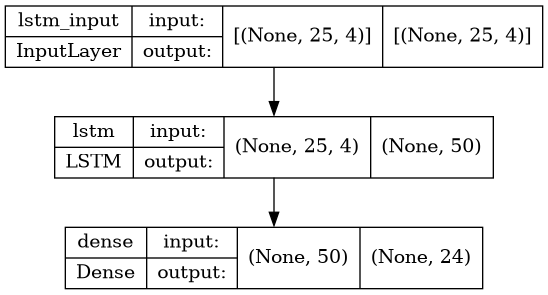

In [10]:
plot_model(model,
           show_shapes = True,
           expand_nested = True)

In [11]:
history = model.fit(ds["x_train"],
                    ds["y_train"],
                    epochs = 20,
                    batch_size = 32,
                    verbose = 1,
                    validation_data = (ds["x_test"], ds["y_test"]),
                    shuffle = False,
                    callbacks = calls)

Epoch 1/20
3682/3682 [==============================] - 51s 13ms/step - loss: 332.3062 - mse: 332.3062 - mae: 14.8328 - val_loss: 324.4944 - val_mse: 324.4944 - val_mae: 14.9734
Epoch 2/20
3682/3682 [==============================] - 49s 13ms/step - loss: 279.4165 - mse: 279.4165 - mae: 13.6080 - val_loss: 287.2481 - val_mse: 287.2481 - val_mae: 13.9028
Epoch 3/20
3682/3682 [==============================] - 48s 13ms/step - loss: 196.9956 - mse: 196.9956 - mae: 10.8323 - val_loss: 180.0960 - val_mse: 180.0960 - val_mae: 10.6615
Epoch 4/20
3682/3682 [==============================] - 50s 14ms/step - loss: 128.4763 - mse: 128.4763 - mae: 8.4721 - val_loss: 164.5567 - val_mse: 164.5567 - val_mae: 10.0862
Epoch 5/20
3682/3682 [==============================] - 49s 13ms/step - loss: 114.3662 - mse: 114.3662 - mae: 7.9092 - val_loss: 152.8237 - val_mse: 152.8237 - val_mae: 9.6821
Epoch 6/20
3682/3682 [==============================] - 51s 14ms/step - loss: 106.0713 - mse: 106.0713 - mae: 7.5

In [12]:
model.save("O3_model/model_24h")

2023-01-14 10:08:29.411664: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: O3_model/model_24h/assets


INFO:tensorflow:Assets written to: O3_model/model_24h/assets


In [13]:
history_df = pd.DataFrame(history.history)

<AxesSubplot:>

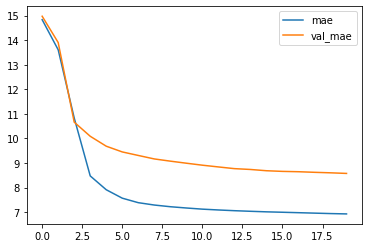

In [14]:
history_df.plot(kind = "line", y = ["mae", "val_mae"])

In [15]:
preds = pd.DataFrame(model.predict(ds["x_test"]))

In [16]:
preds.columns = ["Pred" + str(hour) + "h" for hour in range(1, len(preds.columns) + 1)]
preds.head()

,Pred1h,Pred2h,Pred3h,Pred4h,Pred5h,Pred6h,Pred7h,Pred8h,Pred9h,Pred10h,...,Pred15h,Pred16h,Pred17h,Pred18h,Pred19h,Pred20h,Pred21h,Pred22h,Pred23h,Pred24h
0,18.407413,21.360554,25.952780,32.287228,39.674397,47.128845,53.460579,57.628288,59.260326,58.084499,...,35.453854,31.509361,28.382940,26.111233,24.457331,23.220135,22.106499,20.712978,18.861048,17.980021
1,28.477085,31.960684,37.057739,43.097763,49.438026,55.130852,59.463455,60.905457,59.767132,56.501514,...,30.532972,27.364857,24.801958,22.909760,21.250702,19.984358,19.170897,18.538445,18.777637,20.369411
2,32.580406,36.818966,42.086605,47.491444,52.601013,56.736046,59.143581,58.885376,56.190716,52.079494,...,28.634314,26.398745,24.468637,22.912775,21.212706,19.826336,19.168547,18.892101,20.174946,22.710941
3,39.402950,43.906609,48.381290,52.159012,55.218533,57.285553,57.825871,56.434296,53.017967,48.732208,...,27.019529,25.262451,23.760317,22.598143,21.170023,20.271725,20.406244,21.079939,23.524340,27.207939
4,44.296608,48.461918,51.748371,54.017792,55.444153,55.825317,54.956741,52.829559,49.180843,45.078243,...,25.862059,24.298450,23.039991,22.106258,21.176514,21.042652,22.137125,23.853174,27.272261,31.622822


In [17]:
y_test = pd.DataFrame(ds["y_test"])
y_test.columns = ["Meas" + str(hour) + "h" for hour in range(1, len(y_test.columns) + 1)]
preds = pd.concat([preds, y_test], axis = "columns", ignore_index = False)

In [18]:
preds.head()

,Pred1h,Pred2h,Pred3h,Pred4h,Pred5h,Pred6h,Pred7h,Pred8h,Pred9h,Pred10h,...,Meas15h,Meas16h,Meas17h,Meas18h,Meas19h,Meas20h,Meas21h,Meas22h,Meas23h,Meas24h
0,18.407413,21.360554,25.952780,32.287228,39.674397,47.128845,53.460579,57.628288,59.260326,58.084499,...,39.0,38.0,39.0,37.0,38.0,37.0,39.0,33.0,30.0,19.0
1,28.477085,31.960684,37.057739,43.097763,49.438026,55.130852,59.463455,60.905457,59.767132,56.501514,...,38.0,39.0,37.0,38.0,37.0,39.0,33.0,30.0,19.0,17.0
2,32.580406,36.818966,42.086605,47.491444,52.601013,56.736046,59.143581,58.885376,56.190716,52.079494,...,39.0,37.0,38.0,37.0,39.0,33.0,30.0,19.0,17.0,19.0
3,39.402950,43.906609,48.381290,52.159012,55.218533,57.285553,57.825871,56.434296,53.017967,48.732208,...,37.0,38.0,37.0,39.0,33.0,30.0,19.0,17.0,19.0,22.0
4,44.296608,48.461918,51.748371,54.017792,55.444153,55.825317,54.956741,52.829559,49.180843,45.078243,...,38.0,37.0,39.0,33.0,30.0,19.0,17.0,19.0,22.0,25.0


In [19]:
preds["DateTime"] = ds["dt_test"]

## Compare predictions at different horizons in the future

### Forecast 1 hour

<AxesSubplot:title={'center':'1-hour Ozone Predictions'}, xlabel='Date & Time', ylabel='Ozone Concentration (ppb)'>

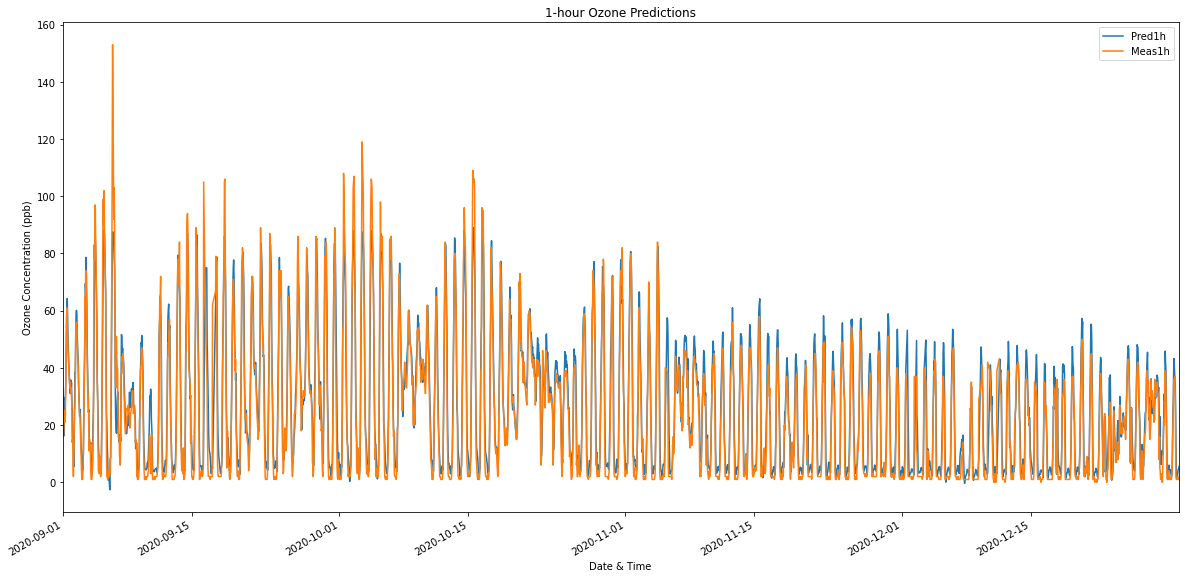

In [20]:
preds.plot(kind = "line",
           y = ["Pred1h", "Meas1h"],
           x = "DateTime",
           title = "1-hour Ozone Predictions",
           xlabel = "Date & Time",
           ylabel = "Ozone Concentration (ppb)",
           figsize = (20, 10),
           xlim = (datetime(2020, 9, 1), datetime(2020, 12, 31)),
           subplots = False)

### Forecast 6 hours

<AxesSubplot:title={'center':'6-hour Ozone Predictions'}, xlabel='Date & Time', ylabel='Ozone Concentration (ppb)'>

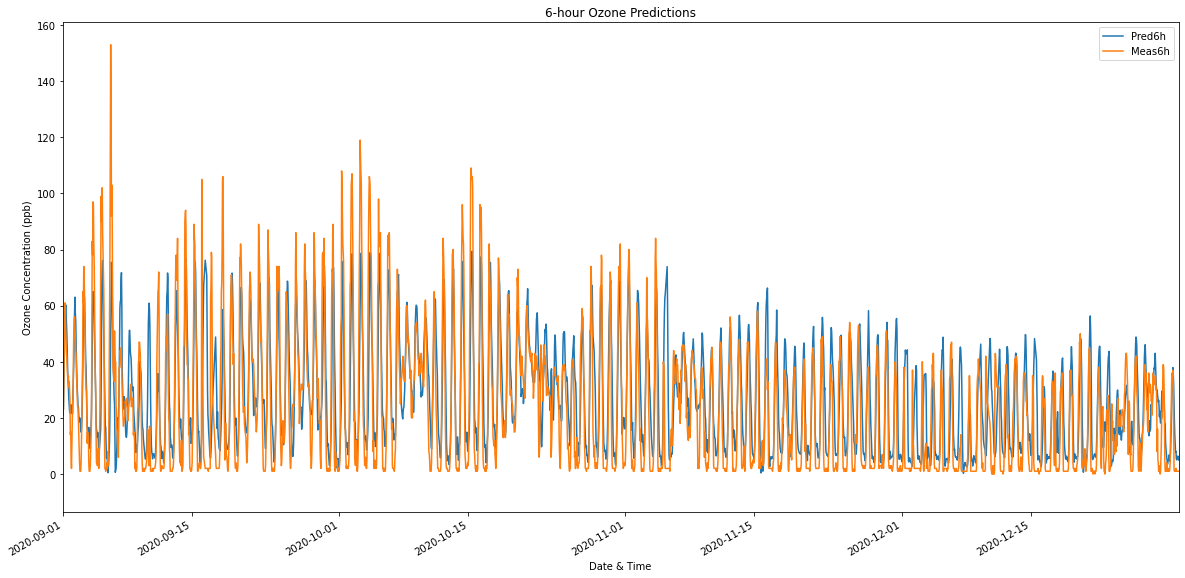

In [21]:
preds.plot(kind = "line",
           y = ["Pred6h", "Meas6h"],
           x = "DateTime",
           title = "6-hour Ozone Predictions",
           xlabel = "Date & Time",
           ylabel = "Ozone Concentration (ppb)",
           figsize = (20, 10),
           xlim = (datetime(2020, 9, 1), datetime(2020, 12, 31)),
           subplots = False)

### Forecast 12 hours

<AxesSubplot:title={'center':'12-hour Ozone Predictions'}, xlabel='Date & Time', ylabel='Ozone Concentration (ppb)'>

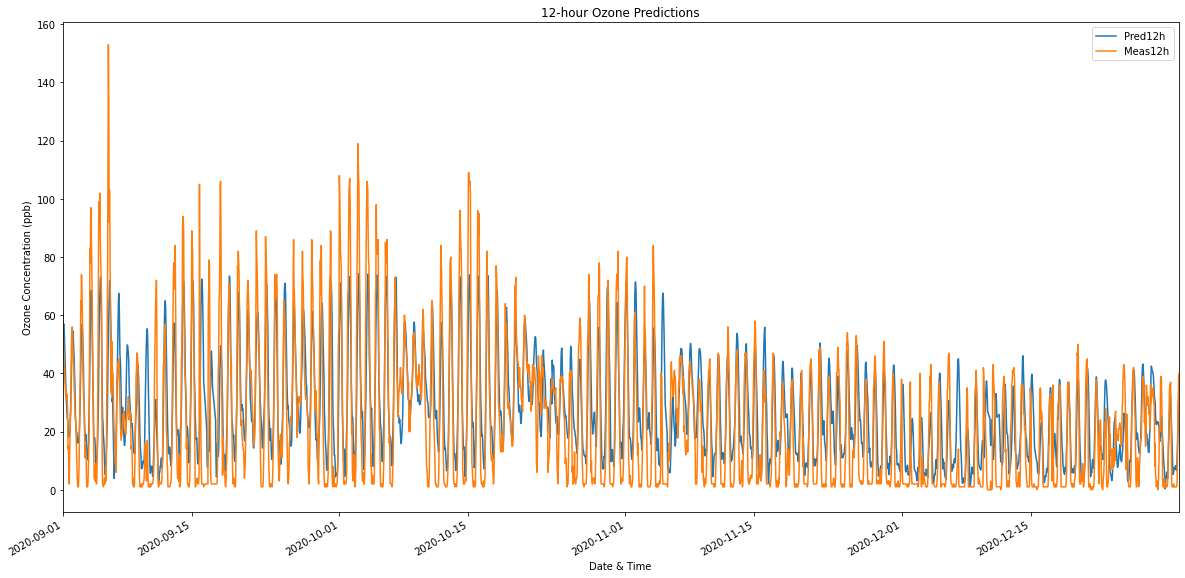

In [22]:
preds.plot(kind = "line",
           y = ["Pred12h", "Meas12h"],
           x = "DateTime",
           title = "12-hour Ozone Predictions",
           xlabel = "Date & Time",
           ylabel = "Ozone Concentration (ppb)",
           figsize = (20, 10),
           xlim = (datetime(2020, 9, 1), datetime(2020, 12, 31)),
           subplots = False)

### Forecast 24 hours

<AxesSubplot:title={'center':'24-hour Ozone Predictions'}, xlabel='Date & Time', ylabel='Ozone Concentration (ppb)'>

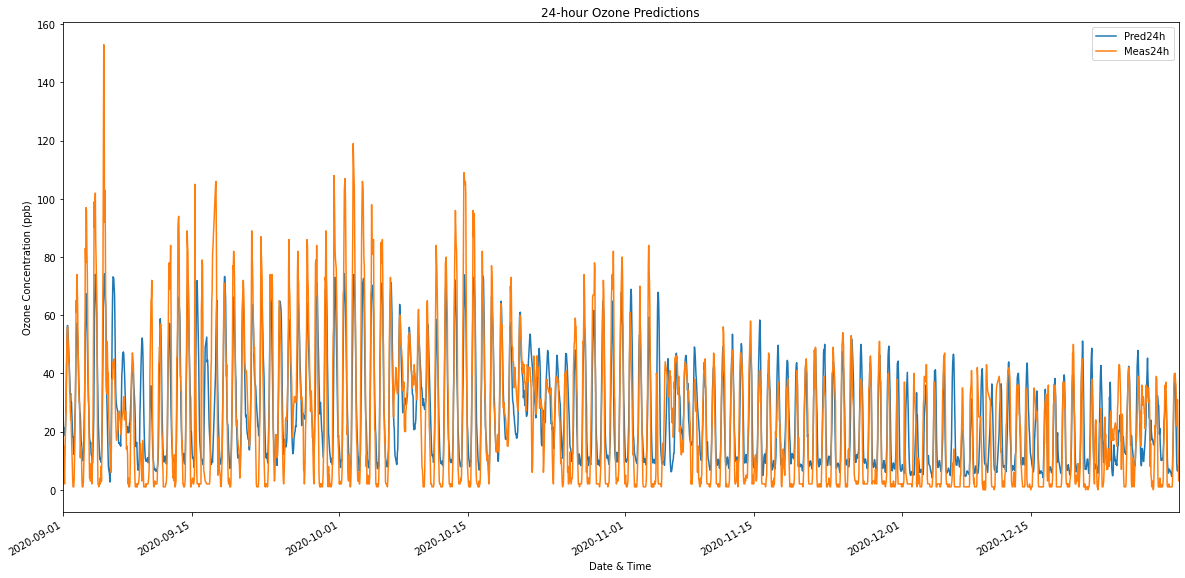

In [23]:
preds.plot(kind = "line",
           y = ["Pred24h", "Meas24h"],
           x = "DateTime",
           title = "24-hour Ozone Predictions",
           xlabel = "Date & Time",
           ylabel = "Ozone Concentration (ppb)",
           figsize = (20, 10),
           xlim = (datetime(2020, 9, 1), datetime(2020, 12, 31)),
           subplots = False)

### Parity plot at a 1-hour horizon

<AxesSubplot:title={'center':'Parity Plot for 1-Hour Ozone Forecast'}, xlabel='Measured Ozone Concentration (ppb)', ylabel='Predicted Ozone Concentration (ppb)'>

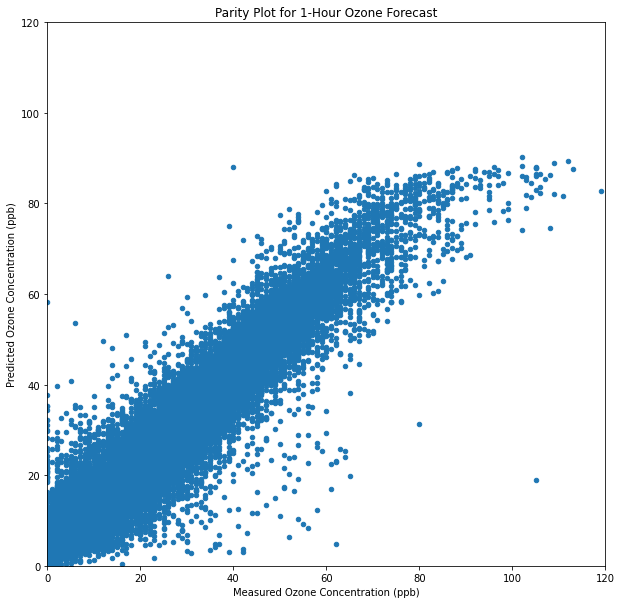

In [24]:
preds.plot(kind = "scatter",
           x = "Meas1h",
           y = "Pred1h",
           title = "Parity Plot for 1-Hour Ozone Forecast",
           xlabel = "Measured Ozone Concentration (ppb)",
           ylabel = "Predicted Ozone Concentration (ppb)",
           figsize = (10, 10),
           xlim = (0, 120),
           ylim = (0, 120),
           subplots = False)

Determine absolute and relative percent error for forecasts at the 1-hour horizon:

In [30]:
preds1h = preds[["Pred1h", "Meas1h"]].dropna(how = "any")
preds1h["AbsError"] = abs(preds1h["Pred1h"] - preds1h["Meas1h"])
preds1h["AbsErrorPercent"] = preds1h["AbsError"] / preds1h["Meas1h"] * 100

In [33]:
print("Mean absolute error: ", preds1h["AbsError"].mean())

Mean absolute error:  4.3904014


In [36]:
print("Median absolute relative percent error: ", preds1h["AbsErrorPercent"].median())

Median absolute relative percent error:  17.045362


### Parity plot at a 12-hour horizon

<AxesSubplot:title={'center':'Parity Plot for 12-Hour Ozone Forecast'}, xlabel='Measured Ozone Concentration (ppb)', ylabel='Predicted Ozone Concentration (ppb)'>

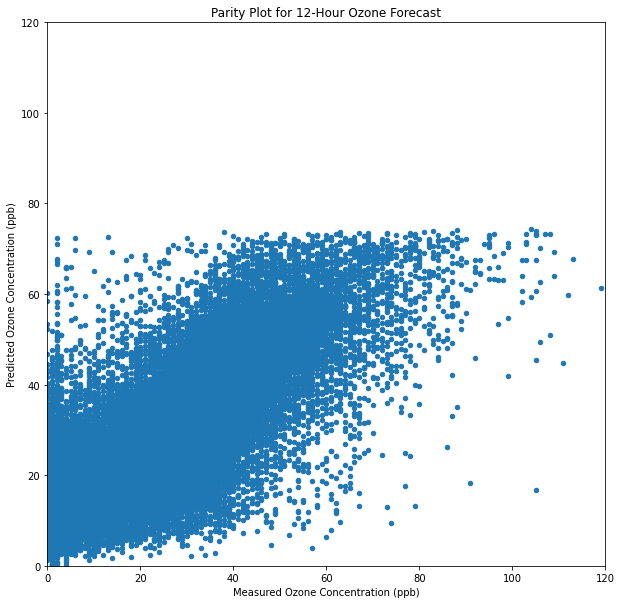

In [37]:
preds.plot(kind = "scatter",
           x = "Meas12h",
           y = "Pred12h",
           title = "Parity Plot for 12-Hour Ozone Forecast",
           xlabel = "Measured Ozone Concentration (ppb)",
           ylabel = "Predicted Ozone Concentration (ppb)",
           figsize = (10, 10),
           xlim = (0, 120),
           ylim = (0, 120),
           subplots = False)

Determine absolute and relative percent error for forecasts at the 12-hour horizon:

In [43]:
preds12h = preds[["Pred12h", "Meas12h"]].dropna(how = "any")
preds12h["AbsError"] = abs(preds12h["Pred12h"] - preds12h["Meas12h"])
preds12h["AbsErrorPercent"] = preds12h["AbsError"] / preds12h["Meas12h"] * 100

In [44]:
print("Mean absolute error: ", preds12h["AbsError"].mean())

Mean absolute error:  9.250084


In [45]:
print("Median absolute relative percent error: ", preds12h["AbsErrorPercent"].median())

Median absolute relative percent error:  33.199215


### Parity plot at a 24-hour horizon

<AxesSubplot:title={'center':'Parity Plot for 24-Hour Ozone Forecast'}, xlabel='Measured Ozone Concentration (ppb)', ylabel='Predicted Ozone Concentration (ppb)'>

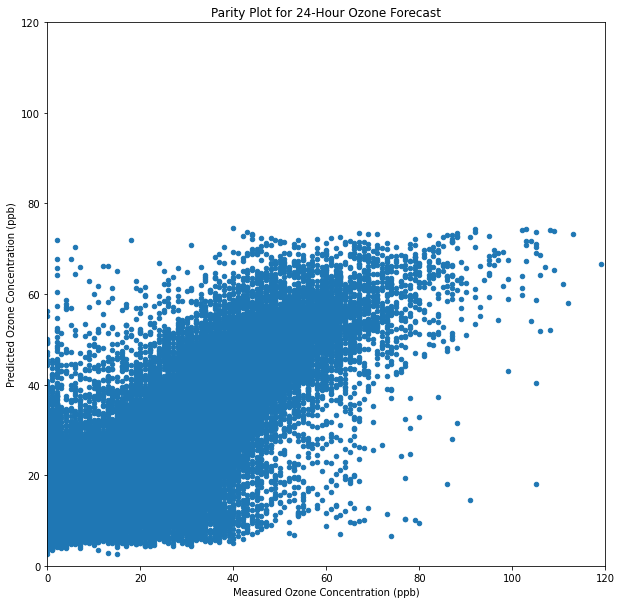

In [39]:
preds.plot(kind = "scatter",
           x = "Meas24h",
           y = "Pred24h",
           title = "Parity Plot for 24-Hour Ozone Forecast",
           xlabel = "Measured Ozone Concentration (ppb)",
           ylabel = "Predicted Ozone Concentration (ppb)",
           figsize = (10, 10),
           xlim = (0, 120),
           ylim = (0, 120),
           subplots = False)

Determine absolute and relative percent error for forecasts at the 24-hour horizon:

Absolute error for 24-hour forecast:

In [40]:
preds24h = preds[["Pred24h", "Meas24h"]].dropna(how = "any")
preds24h["AbsError"] = abs(preds24h["Pred24h"] - preds24h["Meas24h"])
preds24h["AbsErrorPercent"] = preds24h["AbsError"] / preds24h["Meas24h"] * 100

Absolute error for 24-hour forecast:

In [41]:
print("Mean absolute error: ", preds24h["AbsError"].mean())

Mean absolute error:  8.770137


In [42]:
print("Median absolute relative percent error: ", preds24h["AbsErrorPercent"].median())

Median absolute relative percent error:  32.728848


## Takeaways

The model is quite good at capturing the general seasonality of the data, both on a daily horizon and longer.

That said, the 1- and 6-hour predictions more closely match the observed measurements than the 12- and 24-hour predictions.